<a id="toc"></a>

# <u>Table of Contents</u>

1.) [Setup](#setup)  
&nbsp;&nbsp;&nbsp;&nbsp; 1.1.) [Imports](#imports)   
&nbsp;&nbsp;&nbsp;&nbsp; 1.2.) [Load data](#load)   
2.) [Datetime](#datetime)  
&nbsp;&nbsp;&nbsp;&nbsp; 2.1.) [Time Zone](#time_zone)  
&nbsp;&nbsp;&nbsp;&nbsp; 2.2.) [Updated times](#updated_times)  
&nbsp;&nbsp;&nbsp;&nbsp; 2.3.) [Convert to Datetime](#convert_to_datetime)  
&nbsp;&nbsp;&nbsp;&nbsp; 2.4.) [Create year and month features](#create_year_month)  
3.) [Speakers](#speakers)  
&nbsp;&nbsp;&nbsp;&nbsp; 3.1.) [Fill in missing speakers](#speaker_nan)   
&nbsp;&nbsp;&nbsp;&nbsp; 3.2.) [Overview of names](#overview_of_names)   
&nbsp;&nbsp;&nbsp;&nbsp; 3.3.) [Example: Obama](#obama_ex)   
&nbsp;&nbsp;&nbsp;&nbsp; 3.4.) [Remove long names](#long_names)   
&nbsp;&nbsp;&nbsp;&nbsp; 3.5.) [Remove titles, parties, and non-name features](#clean_speakers)   
&nbsp;&nbsp;&nbsp;&nbsp; 3.6.) [Quick Visualization](#speaker_visual)   
4.) [Transcript](#transcript)  
&nbsp;&nbsp;&nbsp;&nbsp; 4.1.) [Process Transcripts](#process_transcripts)   
&nbsp;&nbsp;&nbsp;&nbsp; 4.2.) [Clean Transcripts](#clean_transcripts)   
&nbsp;&nbsp;&nbsp;&nbsp; 4.3.) [Quick sanity check](#transcript_sanity)   
5.) [Misc cleaning](#misc_cleaning)  
&nbsp;&nbsp;&nbsp;&nbsp; 5.1.) [Order dataframe](#misc_order)   
&nbsp;&nbsp;&nbsp;&nbsp; 5.2.) [Remove Speakers if missing Transcript](#misc_speakers)   
&nbsp;&nbsp;&nbsp;&nbsp; 5.3.) [Final data look](#final_data_look)   
6.) [Save to JSON](#save)  
7.) [Tests](#tests)  
&nbsp;&nbsp;&nbsp;&nbsp; 7.1.) [Remove party regex](#test_party_regex)   

In [1]:
import json

In [8]:
import specific_titles

In [11]:
Path(specific_titles.__file__)

NameError: name 'Path' is not defined

In [2]:
from mistakes import mistakes

In [7]:
mistakes.

AttributeError: 'set' object has no attribute '__file__'

In [6]:
mistakes

{'BUT THERE IS A PRIME SUSPECT',
 '',
 'WE LOOK AT WHAT’S HAPPENING WITH ESWAR PRASAD',
 'THE CRIES FOR ACTION ECHOED IN CONGRESS',
 'THE BOOK IS “DOES JESUS REALLY LOVE ME?',
 'TOPS ON THE AGENDA FOR THE TWO LEADERS',
 'EVERYONE SAYS THEY WANT SOMETHING BINDING',
 'THE LETTER READ IN PART',
 'TO DISCUSS THE OPTIONS IN AFGHANISTAN',
 'IN A STATEMENT TO THE ASSOCIATED PRESS',
 'AND A BLACK COLLEAGUE HAD CHALLENGED HER',
 'AND ESSENTIALLY HIS POINT WAS',
 'AND SO I’M LEFT WITH TWO BIG QUESTIONS',
 'THE BOOK IS “HAUNTING LEGACY',
 'CORRESPONDENT JOHN YANG BEGINS OUR COVERAGE',
 'AS FOR TRUMP',
 '*CORRECTION',
 'AS FOR THE WALL STREET WIZARDS',
 'THE LATEST POINT OF DISPUTE',
 'AND A WARNING',
 'A GREAT MARK TWAIN QUOTE',
 'IN A STATEMENT LATE TODAY',
 'IN THE MAJORITY OPINION',
 'ALL OF THIS',
 'READ THE FULL TRANSCRIPT OF THIS SEGMENT BELOW',
 'FROM THE CENTER FOR INVESTIGATIVE REPORTING AND REVEAL',
 'AND I THINK IT’S FAIR TO SAY',
 'THE DOCUMENTARY FILM “AI WEIWEI',
 'TWO OF THOSE SIX 

In [5]:
with open("./mistakes.json", "w") as f:
    json.dump(f, mistakes)

TypeError: Object of type TextIOWrapper is not JSON serializable

---
<a id="setup"></a>

# [^](#toc) <u>Setup</u>

<a id="imports"></a>

### [^](#toc) Imports

In [1]:
### Standard imports
import pandas as pd
import numpy as np

### Plotting imports
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()

import re
import datetime

### Removes warnings that occassionally show in imports
import warnings
warnings.filterwarnings('ignore')

<a id="load"></a>

### [^](#toc) Load data

In [2]:
df = pd.read_json("../data/PBS_full_unedited.json")
df.Speakers   = df.Speakers.map(set)
    
print("Shape of df:", df.shape)
df.head()

Shape of df: (17617, 6)


,Date,Speakers,Story,Title,Transcript,URL
0,"Jul 2, 2018 6:50 PM EDT","{President Donald Trump, Judy Woodruff, Man (t...","In our news wrap Monday, President Trump's sea...",News Wrap: Trump interviews Supreme Court cand...,"[[Judy Woodruff, [ President Trump’s search fo...",https://www.pbs.org/newshour/show/news-wrap-tr...
1,"Jul 2, 2018 6:45 PM EDT","{Judy Woodruff, Andres Manuel Lopez Obrador (t...",Mexican president-elect Andrés Manuel López Ob...,"Elected by a landslide, can Mexico’s López Obr...","[[Judy Woodruff, [ After two previous runs for...",https://www.pbs.org/newshour/show/elected-in-a...
10,"Jun 30, 2018 7:19 PM EDT","{LISA DESJARDINS, DANIEL BUSH}","On this edition for Saturday, June 30, people ...",Stiffer bonds keeping some migrant families ap...,"[[LISA DESJARDINS, [ Despite court orders it i...",https://www.pbs.org/newshour/show/stiffer-bond...
100,"Jun 15, 2018 6:45 PM EDT","{Judy Woodruff, Geng Shuang (through translator)}","In our news wrap Friday, the Trump administrat...",News Wrap: U.S. imposes tariffs on $50B worth ...,"[[Judy Woodruff, [ In the day’s other news, th...",https://www.pbs.org/newshour/show/news-wrap-u-...
1000,"Nov 7, 2017 6:40 PM EDT","{Judy Woodruff, Sen. Chris Murphy}","Sen. Chris Murphy. D-Conn., has been one of th...",Closing gun background check loopholes may be ...,"[[Judy Woodruff, [ As more becomes known about...",https://www.pbs.org/newshour/show/closing-gun-...


---
<a id="datetime"></a>

# [^](#toc) <u>Datetime</u>

First let's clear off whitespace and \n characters

In [3]:
df["Date"] = df["Date"].map(lambda x: x.strip())

<a id="time_zone"></a>

### [^](#toc) Time Zone

It appears, the time is always posted in EDT

In [4]:
df["Timezone"] = df.Date.map(lambda x: x[-3:])
df["Timezone"].value_counts()

EDT    17617
Name: Timezone, dtype: int64

<a id="updated_times"></a>

### [^](#toc) Updated times

There are only 4 videos that were updated.  I don't think this is very interesting so I'm just going to ignore all updated times.

I understand why someone would like this data, but I don't need it.

In [5]:
df.temp = df.Date.map(lambda x: int("Updated" in x))
num_updated = len(df[df.temp == 1])
print(f"{num_updated} clips have had information updated")

df.Date = df.Date.map(lambda x: x.split("\n")[0])

4 clips have had information updated


<a id="convert_to_datetime"></a>

### [^](#toc) Convert to Datetime

See this Stack Exchange [link](https://english.stackexchange.com/questions/35315/what-is-the-proper-name-for-am-and-pm?newreg=2d443a2ca9dc4ba6abbe1a1e01e4af4b) haha.  I was honored by the line...

    software developers think about naming variables properly. It is built into the Object-Oriented mindset. Jader, a commenter, said it well: "It's funny that the question intrinsically is not programming related, but all programmers can understand why you posted it here."
    
I just considered myself a physicist!

In [6]:
def format_datetime(x):
    return datetime.datetime.strptime(x[:-4], '%b %d, %Y %H:%M %p')

df.Date = df.Date.map(format_datetime)

<a id="create_year_month"></a>

### [^](#toc) Create year and month features

In [7]:
df["Year"]  = df.Date.map(lambda x: x.year)
df["Month"] = df.Date.map(lambda x: x.month)

### And we're done with times!

---
<a id="speakers"></a>

# [^](#toc) <u>Speakers</u>

<a id="speaker_nan"></a>

### [^](#toc) Fill in missing speakers

In [8]:
for row in df.loc[df.Speakers.isnull(), 'Speakers'].index:
    df.at[row, 'Speakers'] = {}

<a id="overview_of_names"></a>

### [^](#toc) Overview of names

In [9]:
df.iloc[0].Speakers

{'Judy Woodruff',
 'Justin Herdman',
 'Man (through translator)',
 'President Donald Trump'}

In [10]:
N = len(set.union(*df.Speakers))

print("Unique names found in df:", N)

Unique names found in df: 32720


<a id="obama_ex"></a>

### [^](#toc) Example: Obama

It looks like there's a lot to do here, I want uniform names.

When I search for Obama I want to see 'SEN. BARACK OBAMA', 'SENATOR BARACK OBAMA', 'PRESIDENT BARACK OBAMA', 'PRESIDENT BARACK OBAMA (singing)', 'BARACK OBAMA', 'BARACK OBAMA (singing)', and 'Barack Obama'

My plan of attack is

However removing modifiers only goes so far, sometimes the names are shortened.  In which case I need to manually group "Obama" and "PRESIDENT OBAMA" to "BARACK OBAMA".

There also seems to be ASCII errors like "\xa0" popping up.

In [11]:
{elem for elem in {x for x in set.union(*df.Speakers)} if ("OBAMA" in elem or "Obama" in elem or "obama" in elem)}

{'And I think Obama and Boehner and Reid all know that their legacies are tied together and they reside around one thing',
 'And Obama’s counter will have to be',
 'And President Obama says he will do something few presidents have done',
 'And so that’s what the FTC and the Obama Administration have both called for',
 'Arizona Senator John McCain said today the Obama administration is to blame',
 'BARACK OBAMA',
 'BARACK OBAMA (singing)',
 'Barack Obama',
 'Before a fund-raiser for President Obama',
 'Brookings institution scholar Shadi Hamid credits Mr. Obama for the Iran deal',
 'But the Obama reelection team did wade into the Bain debate with a memo that said',
 'Daniel Benjamin was coordinator for counterterrorism at the State Department during the first term of the Obama administration. He’s now a professor at Dartmouth College. And Joby Warrick is a national security correspondent at The Washington Post. He’s also the author of the book “Black Flags',
 'FIRST LADY MICHELLE OBAMA'

<a id="long_names"></a>

### [^](#toc) Remove long names

Long names are actually text

In [12]:
df.Speakers = df.Speakers.map(lambda x: {elem for elem in x if len(elem.split(" ")) < 9})

<a id="clean_speakers"></a>

### [^](#toc) Remove titles, parties, and non-name features

We went from 32,725 names to 26,834 names.  This is either from dropping bad names or merging two names that are actually the same person.

This is not perfect, PBS does not have a standardized format.  PBS is not considerate of robots as this [example](https://www.pbs.org/newshour/show/trump-considering-sending-troops-afghanistan) shows.  The names start out as full names, but than move to last names.  This makes complete sense to a human in context.  I can't get a machine to understand context though.  Thankfully this type of format is rare and "SREENIVASAN" is a rare name so I can map it to "HARI SREENIVASAN".  "RUBIN" is probably a more common name and less popular on PBS newshour so unfortunately there's nothing I can easily do.

In [13]:
%run preprocessing.py

mistaken_names = get_mistaken_names()

def map_speakers(x):
    return {clean_names(elem) for elem in x if clean_names(elem) not in mistaken_names}

df.Speakers = df.Speakers.map(map_speakers)
N = len(set.union(*df.Speakers))
print("New number of unique names:", N)

New number of unique names: 26795


<a id="speaker_visual"></a>

### [^](#toc) Quick Visualization

There might be more work needed to be done.  I don't know why "S", "T", or "E" are all names.  They seem to be only found in cases where no Transcript is provided.  I'll deal with this issue later

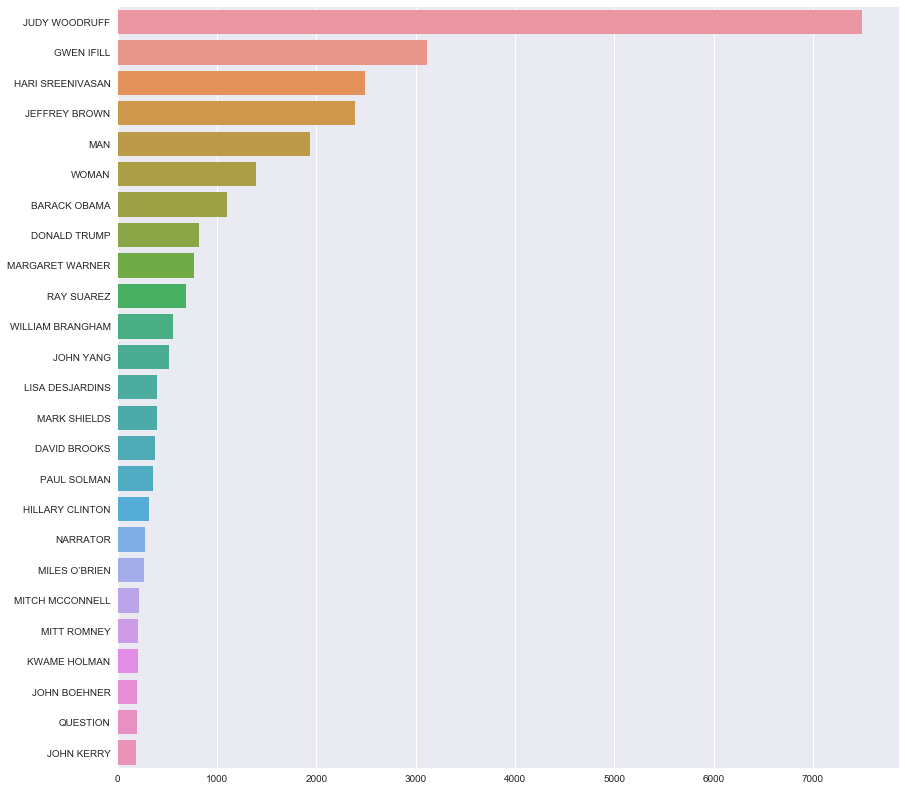

In [14]:
# Will count number of unique words in a sentence
from collections import Counter
import operator
    
persons = df.Speakers.map(list).sum()

freq = sorted(Counter(persons).items(), key=operator.itemgetter(1), reverse=True)

x, y = list(zip(*freq[:25]))
plt.figure(figsize=(14, 14))
sns.barplot(list(y), list(x));

---
<a id="transcript"></a>

# [^](#toc) <u>Transcript</u>

In [15]:
for row in df.loc[df.Transcript.isnull(), 'Transcript'].index:
    df.at[row, 'Transcript'] = []

<a id="process_transcripts"></a>

### [^](#toc) Process Transcripts

Plan of attack

1.) Remove all speakers that should not be included.  
2.) Go through each Transcript and check if it has a Speaker that is not included.  
3.) If this speaker is the first one talking, clip the transcript short.  This is probably more intro if there isn't a direct speaker.  
4.) If the speaker is not the first talker, append the speaker and text to the previous speaker.  

Check out this [video](https://www.pbs.org/newshour/show/with-3-more-wins-romney-pivots-to-general-election#transcript) and search for "North Carolina is a strong one for them".  You'll see one of these formating slips and understand what the problem is.  If you know how to do a webpage inspection, try to figure out a difference between speaker names and emphasized text.  I couldn't

In [16]:
def map_transcript(speakers):
    def map_transcript_helper(x):
        if x is np.nan:
            return x
        
        i = 0
        while i < len(x):
            speeches = x[i]
            if speeches[1] == [""]:
                x[i-1][1].append(speeches[0])
                del x[i]
                i -= 1
            
            elif clean_names(speeches[0]) not in speakers:
                if i == 0:
                    x = x[1:]
                else:
                    temp = speeches[1][:]
                    temp.insert(0, speeches[0])
                    x[i-1][1] = x[i-1][1] + temp

                    del x[i]
                    i -= 1
            i += 1
        return x
    return map_transcript_helper

speakers = set.union(*df.Speakers)
df.Transcript = df.Transcript.map(map_transcript(speakers))

<a id="clean_transcripts"></a>

### [^](#toc) Clean Transcripts

I've only seen newline and space formatting errors (they get rendered as `\n` and `\xa0` respectively)

In [17]:
def clean_transcripts(transcript):
    for i, speaker in enumerate(transcript):
        for j, txt in enumerate(speaker[1:]):
            for k, paragraph in enumerate(txt):
                transcript[i][j+1][k] = paragraph.replace("\n",   " ")
                transcript[i][j+1][k] = paragraph.replace("\xa0", " ")
    return transcript

df.Transcript = df.Transcript.map(clean_transcripts)

<a id="transcript_clean_name"></a>

### [^](#toc) Clean Names

Clean all the names in the Transcript.  I sort of like seeing the titles and qualifiers, however I can't migrate my clean_names preprocessing function to Kaggle so I have to clean here and now.

In [18]:
def clean_name(transcript):
    for i, speaker in enumerate(transcript):
        transcript[i][0] = clean_names(speaker[0])
    return transcript

df.Transcript = df.Transcript.map(clean_name)

<a id="transcript_sanity"></a>

### [^](#toc) Quick sanity check

I'll check a few random transcripts to see if they were formatted correctly

And wow!  This works almost perfectly!  I haven't seen one mistake yet

In [19]:
### Used to style Python print statements
class color:
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'
    END = '\033[0m'

def pretty_transcript(transcript, convert_name=False):
    print(color.BOLD, "TRANSCRIPT", color.END)
    for speaker in transcript:
        if convert_name:
            speaker[0] = clean_names(speaker[0])
        print(color.UNDERLINE, speaker[0] + ":", color.END)
        for txt in speaker[1:]:
            print("  ", " ".join(txt))
        print()
            
for _ in range(5):
    print()
    temp = df[df.Transcript.map(lambda x: x != [])].reset_index(drop=True)
    index = np.random.randint(0, len(temp) - 1)
    print(temp.iloc[index].URL)
    pretty_transcript(temp.iloc[index].Transcript, convert_name=True)


https://www.pbs.org/newshour/show/are-u-s-nuclear-plants-ready-for-a-fukushima-like-meltdown
 TRANSCRIPT 
 JEFFREY BROWN: 
    In the wake of the Fukushima nuclear disaster, how should government regulators here set the safety bar for nuclear power plants in the U.S.? This week, the head of the Nuclear Regulatory Commission announced his resignation, and news reports suggest that battles within the commission over safety requirements may partially account for his departure. NewsHour science correspondent Miles O’Brien has been looking into these bigger questions well before the latest news. His report was produced in partnership with ProPublica.

 MAN: 
    We’re staying on AOP-1 for reactor scrams and AOP-2 for turbine trips. And the immediate actions for AOP-1 reactor scram are complete.

 MILES O’BRIEN: 
    This is a test, only a test. If it were a real nuclear accident in the making, you would know about it by now.

 MAN: 
    Also, right now, we have sustained a loss of RPS, plu

https://www.pbs.org/newshour/show/news-wrap-powerful-typhoon-haiyan-hits-the-philippines
 TRANSCRIPT 
 GWEN IFILL: 
    The most powerful storm on earth this year has hit the central Philippines with sustained winds of nearly 200 miles an hour. Thousands of residents were forced to evacuate, and officials warned of catastrophic damage. Hours before landfall, the typhoon was already dumping heavy rain. The target area included a province devastated by an earthquake just last month. Trans fats could soon disappear from the American diet. The Food and Drug Administration wants to ban the artery-clogging substance found in processed foods from margarine to cookies to frozen pizza. The FDA says that could prevent nearly 7,000 deaths from heart disease each year. We will have more on this right after the news summary. The Senate voted today to ban workplace discrimination against homosexual, bisexual and transgender employees. The outcome underscored the nation’s evolving attitude toward gay

---
<a id="misc_cleaning"></a>

# [^](#toc) <u>Misc cleaning</u>

<a id="misc_order"></a>

### [^](#toc) Order dataframe

In [20]:
df = df.sort_values("Date").reset_index(drop=True)
print("Shape of df:", df.shape)
df.head()

Shape of df: (17617, 9)


,Date,Speakers,Story,Title,Transcript,URL,Timezone,Year,Month
0,1973-05-17 02:26:00,{},“How high did the scandals reach and was Presi...,Watergate: The NewsHour’s 1973 Special Report,[],https://www.pbs.org/newshour/show/robert-macne...,EDT,1973,5
1,1979-06-29 06:00:00,{},This MacNeil/Lehrer Report piece highlights th...,Tempers Flare In Lines for Gasoline in 1979,[],https://www.pbs.org/newshour/show/tempers-flar...,EDT,1979,6
2,1981-02-27 06:00:00,{},Robert MacNeil and Jim Lehrer interviewed Brit...,Newsmaker: Margaret Thatcher,[],https://www.pbs.org/newshour/show/margaret-tha...,EDT,1981,2
3,1982-10-25 06:00:00,{},Jim Lehrer and Charlene Hunter Gault report on...,"The MacNeil/Lehrer Report – October 25, 1982 –...",[],https://www.pbs.org/newshour/show/macneil-lehr...,EDT,1982,10
4,1983-11-30 06:00:00,{},Robert MacNeil and Charlayne Hunter Gault repo...,"The MacNeil/Lehrer Report from Nov. 30, 1983 o...",[],https://www.pbs.org/newshour/show/the-macneil-...,EDT,1983,11


<a id="misc_speakers"></a>

### [^](#toc) Remove Speakers if missing Transcript

In [21]:
index = df[df.Transcript.map(lambda x: x == []) & df.Speakers.map(lambda x: x != {})].index

for row in index:
    df.at[row, 'Speakers'] = {}

df[df.Transcript.map(lambda x: x == []) & df.Speakers.map(lambda x: x != {})]

,Date,Speakers,Story,Title,Transcript,URL,Timezone,Year,Month


<a id="final_data_look"></a>

### [^](#toc) Final data look

In [22]:
df.head()

,Date,Speakers,Story,Title,Transcript,URL,Timezone,Year,Month
0,1973-05-17 02:26:00,{},“How high did the scandals reach and was Presi...,Watergate: The NewsHour’s 1973 Special Report,[],https://www.pbs.org/newshour/show/robert-macne...,EDT,1973,5
1,1979-06-29 06:00:00,{},This MacNeil/Lehrer Report piece highlights th...,Tempers Flare In Lines for Gasoline in 1979,[],https://www.pbs.org/newshour/show/tempers-flar...,EDT,1979,6
2,1981-02-27 06:00:00,{},Robert MacNeil and Jim Lehrer interviewed Brit...,Newsmaker: Margaret Thatcher,[],https://www.pbs.org/newshour/show/margaret-tha...,EDT,1981,2
3,1982-10-25 06:00:00,{},Jim Lehrer and Charlene Hunter Gault report on...,"The MacNeil/Lehrer Report – October 25, 1982 –...",[],https://www.pbs.org/newshour/show/macneil-lehr...,EDT,1982,10
4,1983-11-30 06:00:00,{},Robert MacNeil and Charlayne Hunter Gault repo...,"The MacNeil/Lehrer Report from Nov. 30, 1983 o...",[],https://www.pbs.org/newshour/show/the-macneil-...,EDT,1983,11


In [23]:
df.tail()

,Date,Speakers,Story,Title,Transcript,URL,Timezone,Year,Month
17612,2018-07-02 06:35:00,"{YAMICHE ALCINDOR, DERRICK JOHNSON, WOMAN, HOW...",A profusion of national incidents in which whi...,#LivingWhileBlack: How does racial bias lead t...,"[[JUDY WOODRUFF, [ A number of recent incident...",https://www.pbs.org/newshour/show/livingwhileb...,EDT,2018,7
17613,2018-07-02 06:40:00,"{NAIMI, YAHYA ALHABBARI, LISE GRANDE, STEPHEN ...",One of the poorest countries in the Middle Eas...,Yemen’s spiraling hunger crisis is a man-made ...,"[[JUDY WOODRUFF, [ The “NewsHour” has reported...",https://www.pbs.org/newshour/show/yemens-spira...,EDT,2018,7
17614,2018-07-02 06:43:00,"{ROBERTA JACOBSON, JUDY WOODRUFF}",There are enormous expectations facing the new...,Will U.S.-Mexico policy tensions change under ...,"[[JUDY WOODRUFF, [ And now perspective from fo...",https://www.pbs.org/newshour/show/will-u-s-mex...,EDT,2018,7
17615,2018-07-02 06:45:00,"{MARCOS FASTLICHT, DIANA MERCADO, ANDRES MANUE...",Mexican president-elect Andrés Manuel López Ob...,"Elected by a landslide, can Mexico’s López Obr...","[[JUDY WOODRUFF, [ After two previous runs for...",https://www.pbs.org/newshour/show/elected-in-a...,EDT,2018,7
17616,2018-07-02 06:50:00,"{DONALD TRUMP, MAN, JUSTIN HERDMAN, JUDY WOODR...","In our news wrap Monday, President Trump's sea...",News Wrap: Trump interviews Supreme Court cand...,"[[JUDY WOODRUFF, [ President Trump’s search fo...",https://www.pbs.org/newshour/show/news-wrap-tr...,EDT,2018,7


---
<a id="save"></a>

# [^](#toc) <u>Save to JSON</u>

Now that we've cleaned up our data a bit, let's save it into a different JSON file.

In [24]:
df.to_json("../data/PBS-newhour-clean.json")

---
<a id="tests"></a>

# [^](#toc) <u>Tests</u>

<a id="test_party_regex"></a>

### [^](#toc) Remove party regex

In [24]:
%run preprocessing.py

ex1 = "BARBARA MIKULSKI (D-MD.)"
assert remove_party(ex1) == "BARBARA MIKULSKI" 

ex2 = "JERRY BROWN (D-CALIF.)"
assert remove_party(ex2) == "JERRY BROWN" 

ex3 = "CHUCK SCHUMER (DN.Y.)"
assert remove_party(ex3) == "CHUCK SCHUMER" 

ex4 = "JOHN BOEHNER (R-OH.)"
assert remove_party(ex4) == "JOHN BOEHNER" 

ex5 = "JEFF SESSIONS (R-ALA.)"
assert remove_party(ex5) == "JEFF SESSIONS" 

ex6 = "TODD YOUNG (RIND.)"
assert remove_party(ex6) == "TODD YOUNG" 

ex7 = "DONALD TRUMP"
assert remove_party(ex7) == ex7

ex8 = "PRESIDENT BARACK OBAMA (singing)"
assert remove_party(ex8) == ex8